In [3]:
import numpy as np
import pandas as pd
from sklearn import preprocessing
from sklearn.feature_extraction.text import CountVectorizer
import matplotlib.pyplot as plt
import seaborn as sns
import dateutil
from wordcloud import STOPWORDS
import string
import re
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from collections import defaultdict
from sklearn.decomposition import LatentDirichletAllocation

In [4]:
df_train = pd.read_csv("C:/Users/Philip/PythonProjects/KaggleNLP_SOA/expert_training.csv")
df_test = pd.read_csv("C:/Users/Philip/PythonProjects/KaggleNLP_SOA/expert_testing.csv")

In [5]:
print('Training Set Shape = {}'.format(df_train.shape))
print('Training Set Memory Usage = {:.2f} MB'.format(df_train.memory_usage().sum() / 1024**2))
print('Test Set Shape = {}'.format(df_test.shape))
print('Test Set Memory Usage = {:.2f} MB'.format(df_test.memory_usage().sum() / 1024**2))

Training Set Shape = (26757, 12)
Training Set Memory Usage = 2.09 MB
Test Set Shape = (8921, 11)
Test Set Memory Usage = 0.63 MB


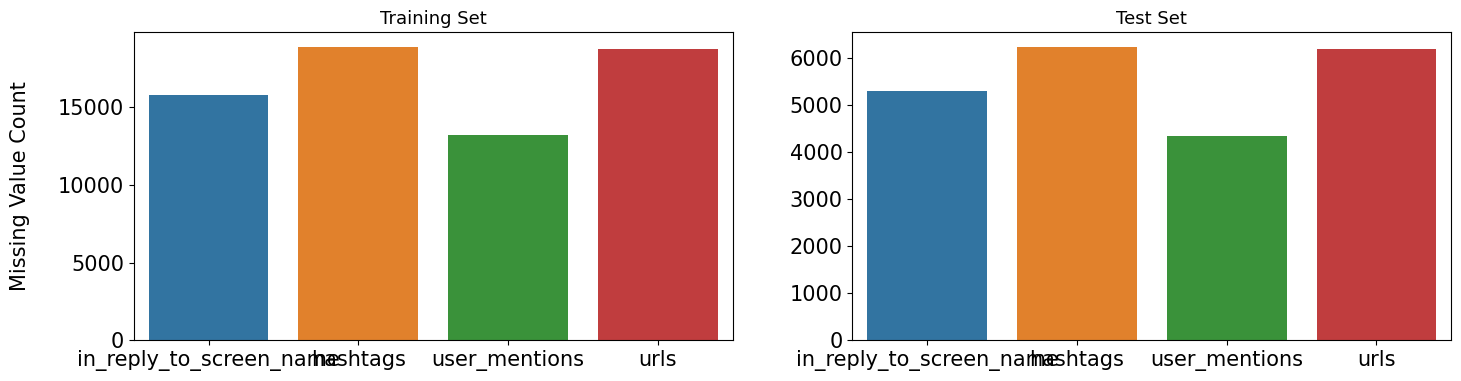

In [6]:
missing_cols = ['in_reply_to_screen_name', 'hashtags', 'user_mentions', 'urls']

fig, axes = plt.subplots(ncols=2, figsize=(17, 4), dpi=100)

sns.barplot(x=df_train[missing_cols].isnull().sum().index, y=df_train[missing_cols].isnull().sum().values, ax=axes[0])
sns.barplot(x=df_test[missing_cols].isnull().sum().index, y=df_test[missing_cols].isnull().sum().values, ax=axes[1])

axes[0].set_ylabel('Missing Value Count', size=15, labelpad=20)
axes[0].tick_params(axis='x', labelsize=15)
axes[0].tick_params(axis='y', labelsize=15)
axes[1].tick_params(axis='x', labelsize=15)
axes[1].tick_params(axis='y', labelsize=15)

axes[0].set_title('Training Set', fontsize=13)
axes[1].set_title('Test Set', fontsize=13)

plt.show()

for df in [df_train, df_test]:
    df['in_reply_to_screen_name'] = df['in_reply_to_screen_name'].fillna(f'no_reply')
    for col in ['hashtags', 'user_mentions', 'urls']:
        df[col] = df[col].fillna(f'no_{col}')

## User data

In [7]:
unique_accounts_train = df_train['screen_name'].unique()
unique_accounts_test = df_test['screen_name'].unique()
unique_reply_accounts_train = df_train['in_reply_to_screen_name'].unique()
unique_reply_accounts_test = df_test['in_reply_to_screen_name'].unique()

intersection_name = np.intersect1d(unique_accounts_train, unique_accounts_test)
intersection_name_reply = np.intersect1d(unique_reply_accounts_train, unique_reply_accounts_test)

train_only = np.setdiff1d(unique_accounts_train, unique_accounts_test)
test_only = np.setdiff1d(unique_accounts_test, unique_accounts_train)

train_reply_only = np.setdiff1d(unique_reply_accounts_train, unique_reply_accounts_test)
test_reply_only = np.setdiff1d(unique_reply_accounts_test, unique_reply_accounts_train)

final_list = np.concatenate((intersection_name, train_only, test_only))
final_list_replies = np.concatenate((intersection_name_reply, train_reply_only, test_reply_only))

print(f"Total accounts: {len(final_list)}")
print(f"Intersection: {len(intersection_name)}")
print(f"Unique to train set: {len(train_only)}")
print(f"Unique to test set: {len(test_only)}")

# Replies are too unique, not used further
print(f"Total reply accounts: {len(final_list_replies)}")
print(f"Intersection reply account: {len(intersection_name_reply)}")
print(f"Unique to train set reply account: {len(train_reply_only)}")
print(f"Unique to test set reply account: {len(test_reply_only)}")

Total accounts: 1410
Intersection: 1344
Unique to train set: 57
Unique to test set: 9
Total reply accounts: 8242
Intersection reply account: 1090
Unique to train set reply account: 5536
Unique to test set reply account: 1616


In [8]:
# 14 accounts are unavailable / suspended.
accounts_data = pd.read_csv("C:/Users/Philip/PythonProjects/KaggleNLP_SOA/accounts_data.csv", encoding='Windows-1252')
accounts_data.drop(columns=['Unnamed: 0'], inplace=True)


In [10]:
# Merge webscrapped user data with train and test sets
df_train_user = pd.merge(df_train, accounts_data, left_on='screen_name', right_on = 'username', how = 'left')
df_test_user = pd.merge(df_test, accounts_data, left_on='screen_name', right_on = 'username', how = 'left')
df_train_user.drop(columns=['username'], inplace=True)
df_test_user.drop(columns=['username'], inplace=True)

In [11]:
na_counts = df_test_user.isna().sum().reset_index()
na_counts.columns = ['column', 'missing_values']
print(na_counts)

                     column  missing_values
0                  tweet_id               0
1               screen_name               0
2                created_at               0
3                 full_text               0
4        display_text_range               0
5   in_reply_to_screen_name               0
6           is_quote_status               0
7            includes_media               0
8                  hashtags               0
9             user_mentions               0
10                     urls               0
11          followers_count              70
12          following_count              70
13              tweet_count              70
14                join_date              70
15              is_verified              70
16                 location              70
17              likes_count              70
18              media_count              70
19         user_description              70
20              lists_count              70
21            friends_count     

In [12]:
# Fill all missing values from the missing accounts with the median / appropriate values of values.
df_train_user['following_count'] = df_train_user['following_count'].fillna(df_train_user['following_count'].median())
df_train_user['followers_count'] = df_train_user['followers_count'].fillna(df_train_user['followers_count'].median())
df_train_user['tweet_count'] = df_train_user['tweet_count'].fillna(df_train_user['tweet_count'].median())
df_train_user['join_date'] = pd.to_datetime(df_train_user['join_date'])
df_train_user['join_date'] = df_train_user['join_date'].fillna(df_train_user['join_date'].median())
df_train_user['is_verified'] = df_train_user['is_verified'].fillna('false')
df_train_user['likes_count'] = df_train_user['likes_count'].fillna(df_train_user['likes_count'].median())
df_train_user['media_count'] = df_train_user['media_count'].fillna(df_train_user['media_count'].median())
df_train_user['user_description'] = df_train_user['user_description'].fillna('no_description')
df_train_user['lists_count'] = df_train_user['lists_count'].fillna(df_test_user['lists_count'].median())
df_train_user['friends_count'] = df_train_user['friends_count'].fillna(df_test_user['friends_count'].median())
df_train_user['location'] = df_train_user['location'].fillna('0')


df_test_user['following_count'] = df_test_user['following_count'].fillna(df_test_user['following_count'].median())
df_test_user['followers_count'] = df_test_user['followers_count'].fillna(df_test_user['followers_count'].median())
df_test_user['tweet_count'] = df_test_user['tweet_count'].fillna(df_test_user['tweet_count'].median())
df_test_user['join_date'] = pd.to_datetime(df_test_user['join_date'])
df_test_user['join_date'] = df_test_user['join_date'].fillna(df_test_user['join_date'].median())
df_test_user['is_verified'] = df_test_user['is_verified'].fillna('false')
df_test_user['likes_count'] = df_test_user['likes_count'].fillna(df_test_user['likes_count'].median())
df_test_user['media_count'] = df_test_user['media_count'].fillna(df_test_user['media_count'].median())
df_test_user['user_description'] = df_test_user['user_description'].fillna('no_description')
df_test_user['lists_count'] = df_test_user['lists_count'].fillna(df_test_user['lists_count'].median())
df_test_user['friends_count'] = df_test_user['friends_count'].fillna(df_test_user['friends_count'].median())
df_test_user['location'] = df_test_user['location'].fillna('0')

In [13]:
# Trying out some features
df_train_user['has_location'] = df_train_user['location'].apply(lambda x: 0 if x == '0' else 1)
df_test_user['has_location'] = df_test_user['location'].apply(lambda x: 0 if x == '0' else 1)
df_train_user['has_description'] = df_train_user['user_description'].apply(lambda x: 0 if x == '0' else 1)
df_test_user['has_description'] = df_test_user['user_description'].apply(lambda x: 0 if x == '0' else 1)
df_train_user['following_followers_ratio'] = np.where(df_train_user['following_count'] == 0, df_train_user['followers_count'] / 1, df_train_user['followers_count'] / df_train_user['following_count'])
df_test_user['following_followers_ratio'] = np.where(df_test_user['following_count'] == 0, df_test_user['followers_count'] / 1, df_test_user['followers_count'] / df_test_user['following_count'])

In [14]:
top_screen_names = df_train_user.groupby('screen_name')['engagement_count'].mean().sort_values(ascending=False).head(10).to_frame().reset_index()
print(top_screen_names)

       screen_name  engagement_count
0   cryptoworld_gg      15504.666667
1  CoinersTakingLs      14555.272727
2         ethereum      12901.000000
3      NFTWizzardX       4602.166667
4      ethphoenix_       4400.135135
5      CryptoCapo_       4337.576923
6          SirKunt       4265.214286
7      MrNFTexpert       3629.076923
8    ElinaGiveaway       3436.500000
9          russnft       3357.500000


Words processing / meta features

In [15]:
# word_count
df_train_user['word_count'] = df_train_user['full_text'].apply(lambda x: len(str(x).split()))
df_test_user['word_count'] = df_test_user['full_text'].apply(lambda x: len(str(x).split()))

# unique_word_count
df_train_user['unique_word_count'] = df_train_user['full_text'].apply(lambda x: len(set(str(x).split())))
df_test_user['unique_word_count'] = df_test_user['full_text'].apply(lambda x: len(set(str(x).split())))

# stop_word_count
df_train_user['stop_word_count'] = df_train_user['full_text'].apply(lambda x: len([w for w in str(x).lower().split() if w in STOPWORDS]))
df_test_user['stop_word_count'] = df_test_user['full_text'].apply(lambda x: len([w for w in str(x).lower().split() if w in STOPWORDS]))

# url_count
df_train_user['url_count'] = df_train_user['full_text'].apply(lambda x: len([w for w in str(x).lower().split() if 'http' in w or 'https' in w]))
df_test_user['url_count'] = df_test_user['full_text'].apply(lambda x: len([w for w in str(x).lower().split() if 'http' in w or 'https' in w]))

# mean_word_length
df_train_user['mean_word_length'] = df_train_user['full_text'].apply(lambda x: np.mean([len(w) for w in str(x).split()]))
df_test_user['mean_word_length'] = df_test_user['full_text'].apply(lambda x: np.mean([len(w) for w in str(x).split()]))

# punctuation_count
df_train_user['punctuation_count'] = df_train_user['full_text'].apply(lambda x: len([c for c in str(x) if c in string.punctuation]))
df_test_user['punctuation_count'] = df_test_user['full_text'].apply(lambda x: len([c for c in str(x) if c in string.punctuation]))

# hashtag_count
df_train_user['hashtag_count'] = df_train_user['full_text'].apply(lambda x: len([c for c in str(x) if c == '#']))
df_test_user['hashtag_count'] = df_test_user['full_text'].apply(lambda x: len([c for c in str(x) if c == '#']))

# mention_count
df_train_user['mention_count'] = df_train_user['full_text'].apply(lambda x: len([c for c in str(x) if c == '@']))
df_test_user['mention_count'] = df_test_user['full_text'].apply(lambda x: len([c for c in str(x) if c == '@']))

## Cleaning Tweets / Basic NLP 
LDA for topic extraction, vaderSentiment for sentiment analysis

In [16]:
# Some basic helper functions to clean text by removing urls, emojis, html tags and punctuations.

def remove_URL(text):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'', text)


def remove_emoji(text):
    emoji_pattern = re.compile(
        '['
        u'\U0001F600-\U0001F64F'  # emoticons
        u'\U0001F300-\U0001F5FF'  # symbols & pictographs
        u'\U0001F680-\U0001F6FF'  # transport & map symbols
        u'\U0001F1E0-\U0001F1FF'  # flags (iOS)
        u'\U00002702-\U000027B0'
        u'\U000024C2-\U0001F251'
        ']+',
        flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)


def remove_html(text):
    html = re.compile(r'<.*?>|&([a-z0-9]+|#[0-9]{1,6}|#x[0-9a-f]{1,6});')
    return re.sub(html, '', text)


def remove_punct(text):
    table = str.maketrans('', '', string.punctuation)
    return text.translate(table)

# Applying helper functions

df_train_user['text_clean'] = df_train_user['full_text'].apply(lambda x: remove_URL(x))
df_train_user['text_clean'] = df_train_user['text_clean'].apply(lambda x: remove_emoji(x))
df_train_user['text_clean'] = df_train_user['text_clean'].apply(lambda x: remove_html(x))
df_train_user['text_clean'] = df_train_user['text_clean'].apply(lambda x: remove_punct(x))
df_test_user['text_clean'] = df_test_user['full_text'].apply(lambda x: remove_URL(x))
df_test_user['text_clean'] = df_test_user['text_clean'].apply(lambda x: remove_emoji(x))
df_test_user['text_clean'] = df_test_user['text_clean'].apply(lambda x: remove_html(x))
df_test_user['text_clean'] = df_test_user['text_clean'].apply(lambda x: remove_punct(x))

In [17]:
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(df_train_user['text_clean'])

# transform test data using the same vectorizer
X_test_counts = count_vect.transform(df_test_user['text_clean'])

# initialize LDA model and fit on training data
lda = LatentDirichletAllocation(n_components=5)
doc_term_matrix = lda.fit_transform(X_train_counts)

# transform training and test data to topic distributions
topic_predictions_train = lda.transform(X_train_counts)
topic_predictions_test = lda.transform(X_test_counts)

# attach topic distributions to original dataframes
df_train_user = pd.concat([df_train_user, pd.DataFrame(topic_predictions_train)], axis=1)
df_test_user = pd.concat([df_test_user, pd.DataFrame(topic_predictions_test)], axis=1)

In [18]:
analyzer = SentimentIntensityAnalyzer()
df_train_user['neg_sentiment'] = df_train_user['full_text'].apply(lambda x: analyzer.polarity_scores(x)['neg'])
df_train_user['neutral_sentiment'] = df_train_user['full_text'].apply(lambda x: analyzer.polarity_scores(x)['neu'])
df_train_user['pos_sentiment'] = df_train_user['full_text'].apply(lambda x: analyzer.polarity_scores(x)['pos'])
df_train_user['compound_sentiment'] = df_train_user['full_text'].apply(lambda x: analyzer.polarity_scores(x)['compound'])
df_train_user['emotional_divergence'] = (df_train_user['pos_sentiment'] + df_train_user['neg_sentiment'])/2

df_test_user['neg_sentiment'] = df_test_user['full_text'].apply(lambda x: analyzer.polarity_scores(x)['neg'])
df_test_user['neutral_sentiment'] = df_test_user['full_text'].apply(lambda x: analyzer.polarity_scores(x)['neu'])
df_test_user['pos_sentiment'] = df_test_user['full_text'].apply(lambda x: analyzer.polarity_scores(x)['pos'])
df_test_user['compound_sentiment'] = df_test_user['full_text'].apply(lambda x: analyzer.polarity_scores(x)['compound'])
df_test_user['emotional_divergence'] = (df_test_user['pos_sentiment'] + df_test_user['neg_sentiment'])/2

## Time related data

In [23]:
def convert(dt_tweet):
    dt = dateutil.parser.parse(dt_tweet).replace(tzinfo=dateutil.tz.UTC)
    return dt.astimezone(dateutil.tz.gettz('UTC'))

df_train_user['created_at'] = df_train_user['created_at'].apply(convert)
df_test_user['created_at'] = df_test_user['created_at'].apply(convert)

In [24]:
# Create new columns for year, month, day, hour, and day of week
df_train_user['year'] = df_train_user['created_at'].dt.year
df_train_user['month'] = df_train_user['created_at'].dt.month
df_train_user['day'] = df_train_user['created_at'].dt.day
df_train_user['hour'] = df_train_user['created_at'].dt.hour
df_train_user['day_of_week'] = df_train_user['created_at'].dt.dayofweek
df_train_user['yearmonthdate'] = df_train_user['created_at'].dt.strftime('%Y%m%d')

df_test_user['created_at'] = pd.to_datetime(df_test_user['created_at'])
df_test_user['year'] = df_test_user['created_at'].dt.year
df_test_user['month'] = df_test_user['created_at'].dt.month
df_test_user['day'] = df_test_user['created_at'].dt.day
df_test_user['hour'] = df_test_user['created_at'].dt.hour
df_test_user['day_of_week'] = df_test_user['created_at'].dt.dayofweek
df_test_user['yearmonthdate'] = df_test_user['created_at'].dt.strftime('%Y%m%d')

In [25]:
def get_year_period(month):
    if month in [1, 2]:
        return 1
    elif month in [3, 4, 5, 6, 7, 8]:
        return 2
    elif month in [9, 10, 11, 12]:
        return 3
    else:
        return None  # handle invalid input

df_train_user['year_period'] = df_train_user['month'].apply(get_year_period)
df_test_user['year_period'] = df_test_user['month'].apply(get_year_period)

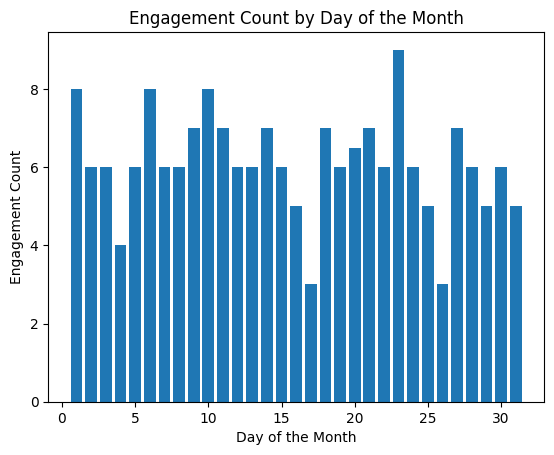

In [26]:
daily_engagement = df_train_user.groupby("day")["engagement_count"].median()

# Create a line plot of daily engagement
plt.bar(daily_engagement.index, daily_engagement.values)
plt.xlabel("Day of the Month")
plt.ylabel("Engagement Count")
plt.title("Engagement Count by Day of the Month")
plt.show()

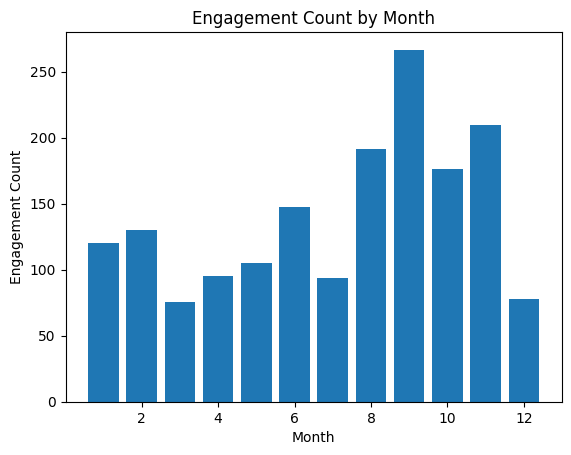

month
1      3796
2     14485
3       412
4       394
5       483
6       519
7       602
8       627
9       733
10     1110
11     1728
12     1868
Name: full_text, dtype: int64


In [27]:
month_engagement = df_train_user.groupby("month")["engagement_count"].mean()
month_tweets = df_train_user.groupby("month")["full_text"].count()

# Create a line plot of daily engagement
plt.bar(month_engagement.index, month_engagement.values)
plt.xlabel("Month")
plt.ylabel("Engagement Count")
plt.title("Engagement Count by Month")

plt.show()
print(month_tweets)

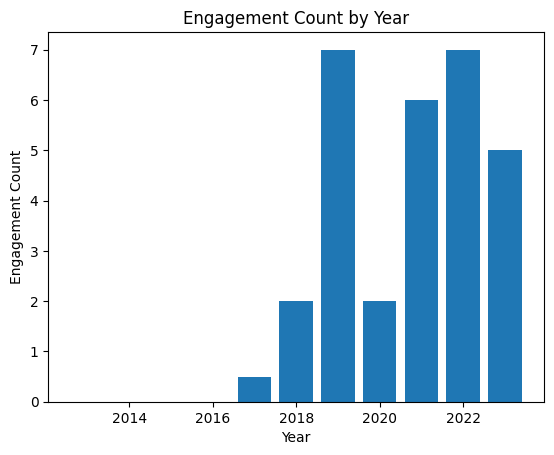

In [28]:
year_engagement = df_train_user.groupby("year")["engagement_count"].median()

# Create a line plot of daily engagement
plt.bar(year_engagement.index, year_engagement.values)
plt.xlabel("Year")
plt.ylabel("Engagement Count")
plt.title("Engagement Count by Year")
plt.show()

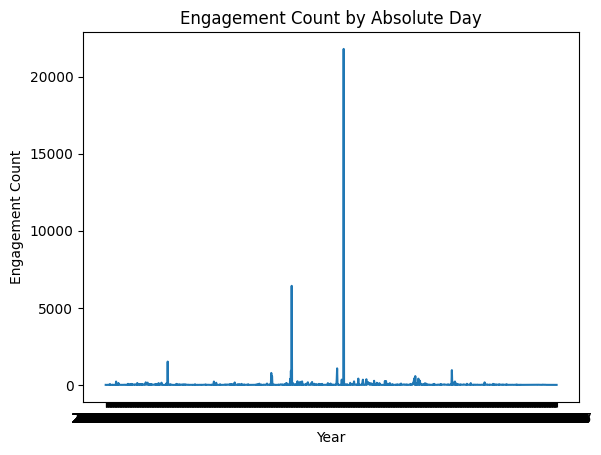

In [29]:
general = df_train_user.groupby("yearmonthdate")["engagement_count"].median()

# Create a line plot of daily engagement
plt.plot(general.index, general.values)
plt.xlabel("Year")
plt.ylabel("Engagement Count")
plt.title("Engagement Count by Absolute Day")
plt.show()

In [30]:
# Days since registration
def to_naive(dt_aware):
    return dt_aware.tz_convert('UTC').tz_localize(None)

df_train_user['created_at'] = df_train_user['created_at'].apply(to_naive)
df_train_user['days_since_join'] = (df_train_user['created_at'] - df_train_user['join_date']).dt.days
df_test_user['created_at'] = df_test_user['created_at'].apply(to_naive)
df_test_user['days_since_join'] = (df_test_user['created_at'] - df_test_user['join_date']).dt.days

In [31]:
# Hours (cyclical encoding)

df_train_user['sin_hour'] = np.sin(2*np.pi*df_train_user['hour']/24.0)
df_train_user['cos_hour'] = np.cos(2*np.pi*df_train_user['hour']/24.0)
df_test_user['sin_hour'] = np.sin(2*np.pi*df_test_user['hour']/24.0)
df_test_user['cos_hour'] = np.cos(2*np.pi*df_test_user['hour']/24.0)

In [32]:
# Ratio of tweets since join date (to catch "spammers")

df_train_user['tweets_since_join'] = np.where(df_train_user['days_since_join'] == 0, df_train_user['tweet_count'] / 1, df_train_user['tweet_count'] / df_train_user['days_since_join'])
df_test_user['tweets_since_join'] = np.where(df_test_user['days_since_join'] == 0, df_test_user['tweet_count'] / 1, df_test_user['tweet_count'] / df_test_user['days_since_join'])

In [33]:
# Number of hashtags and number of mentions

df_train_user['hashtags_count'] = df_train_user['hashtags'].apply(lambda x: x.count(',') + 1 if 'no_hashtags' not in x else 0)
df_test_user['hashtags_count'] = df_train_user['hashtags'].apply(lambda x: x.count(',') + 1 if 'no_hashtags' not in x else 0)

df_train_user['mentions_count'] = df_train_user['user_mentions'].apply(lambda x: x.count(',') + 1 if 'no_user_mentions' not in x else 0)
df_test_user['mentions_count'] = df_train_user['user_mentions'].apply(lambda x: x.count(',') + 1 if 'no_user_mentions' not in x else 0)

In [34]:
# We only check if a tweet is a reply or not. Same thing for URL, but the work is already done in the includes_media column.

df_train_user['is_reply'] = df_train_user['in_reply_to_screen_name'].apply(lambda x: False if x == 'no_reply' else True)
df_test_user['is_reply'] = df_test_user['in_reply_to_screen_name'].apply(lambda x: False if x == 'no_reply' else True)

In [35]:
# Booleans
lb = preprocessing.LabelBinarizer()
df_train_user['is_reply'] = lb.fit_transform(df_train_user['is_reply'])
df_test_user['is_reply'] = lb.fit_transform(df_test_user['is_reply'])
df_train_user['is_quote_status'] = lb.fit_transform(df_train_user['is_quote_status'])
df_test_user['is_quote_status'] = lb.fit_transform(df_test_user['is_quote_status'])
df_train_user['includes_media'] = lb.fit_transform(df_train_user['includes_media'])
df_test_user['includes_media'] = lb.fit_transform(df_test_user['includes_media'])
df_train_user['is_verified'] = df_train_user['is_verified'].apply(lambda x: 0 if x == 'false' else 1)
df_test_user['is_verified'] = df_test_user['is_verified'].apply(lambda x: 0 if x == 'false' else 1)

In [36]:
# Dummy times, ended up removing a lot of these
df_train_user = pd.get_dummies(df_train_user, columns=['year_period', 'year', 'day_of_week'])
df_test_user = pd.get_dummies(df_test_user, columns=['year_period', 'year', 'day_of_week'])


In [ ]:
df_train_user.to_csv("C:/Users\Philip/PythonProjects/KaggleNLP_SOA/data_train_user_clean.csv", index=False)
df_test_user.to_csv("C:/Users\Philip/PythonProjects/KaggleNLP_SOA/data_test_user_clean.csv", index=False)